In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sksurv.ensemble import RandomSurvivalForest 
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.pipeline import  make_pipeline
from sksurv.metrics import concordance_index_censored,concordance_index_ipcw
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import joblib
import seaborn as sns


In [2]:
train = pd.read_csv('./data/post_overall/HCC OP 20230511 train_post_input_derived features_std.csv')
test = pd.read_csv('./data/post_overall/HCC OP 20230511 test_post_input_derived features_std.csv')
display(train.head())

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,lnAST,lnAFP,lnGGT,lnCHOL,lnALK-P,lnLDH,lnGLU,lnHistologic grade,Recur,Recurrence free survival
0,1.17715,-0.532117,-0.539676,-0.234858,1.344577,-0.121387,-0.504872,-0.805649,-0.068955,0.041205,...,-0.156292,-0.807656,-0.907403,-1.519065,-0.505649,-0.453840,-0.356702,0.634366,1.0,3.33
1,1.17715,1.550020,-0.539676,-0.234858,-0.128327,-0.121387,0.440098,0.593904,0.136021,0.134908,...,0.964244,2.669274,0.719674,0.266724,0.607028,0.419324,0.112325,1.416006,1.0,25.97
2,1.17715,2.057229,-0.539676,-0.234858,-0.128327,-0.121387,-1.211471,-0.619867,-1.098584,0.416016,...,2.444676,0.626322,0.795123,1.005668,0.811199,0.763201,-0.431825,0.634366,1.0,15.50
3,-0.84951,0.157487,1.852964,-0.234858,-0.128327,-0.121387,-1.534975,-1.722170,-0.870640,0.134908,...,-0.365717,0.932134,-0.907403,-0.026949,-0.178526,0.718094,2.254512,0.634366,0.0,112.73
4,1.17715,-0.447999,-0.539676,4.257890,2.817480,-0.121387,-0.394200,-0.099680,-0.394531,0.275462,...,-0.604115,0.952768,0.116825,-0.288781,0.961794,-1.260662,1.982285,-0.322283,0.0,7.07


In [3]:
##使用所有特徵再挑一次的結果
# selected = ['Tumor number', 'Tumor size' ,'lnAST' ,'class_Tumor size' ,'MVI' ,'class_AFP',
#  'FIB4', 'class_Steatosis grade', 'class_ALT', 'GLU', 'lnALT',
#  'Image_Vasulcar_invasion(Portal vein,Hepatic vein)' ,'HBsAg', 'Ishak',
#  'lnLDH', 'lnCR', 'APRI', 'BUN', 'HCV' ,'K', 'ALB', 'PTINR', 'HB']
##使用術前特徵挑一次後固定住術前特徵再加入術後特徵再挑
# selected = ['Tumor size', 'BCLC', 'Tumor number', 'MVI', 'lnAST', 'class_AFP', 'class_AST',
#  'HCV', 'Ishak' ,'class_Steatosis grade', 'AST' ,'HBsAg']
##使用術前特徵挑一次後固定住術前特徵再加入術後特徵
# selected = ['lnAST', 'Tumor size', 'class_AFP', 'BCLC' ,'class_Tumor size', 'Tumor number','AST' ,'ALBIgrade', 'HB', 'class_AST', 'AFP', 'HBsAg', 'lnGGT', 'class_BILI',
#  'lnBUN', 'BILI', 'APRI', 'PTINR' ,'lnALT' ,'Sex', 'FIB4', 'Na' ,'Height','class_BMI', 'HCV' ,'lnLDH', 'lnCR','MVI', 'Inflammation', 'Ishak', 'class_Steatosis grade','lnHistologic grade']
##單純使用術後特徵
# selected = ['MVI', 'Inflammation', 'Ishak', 'class_Steatosis grade','lnHistologic grade']
selected = ['Tumor size', 'lnAST' , 'BCLC','Tumor number', 'ALBIgrade',
 'class_Histologic grade', 'class_AFP', 'Ishak','Steatosis grade', 'K' ,'class_Steatosis grade','MVI','BMI'
 ,'AST','HBsAg',]

In [4]:
X = train[ selected ]
y_struct = train[['Recur', 'Recurrence free survival']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])


In [5]:
coxnet = CoxnetSurvivalAnalysis()
coxnet.fit(X, y_struct)
print("fitted.")

fitted.


In [6]:
preds_train = coxnet.predict(X)
concordance_index_censored(train['Recur'] > 0, train['Recurrence free survival'],preds_train)

#concordance_index_ipcw((censored_test, survival_test, preds ))

(0.6995059798948386, 264074, 113441, 0, 84)

In [7]:
test_X_std = test[train.columns].drop(columns=['Recur', 'Recurrence free survival'])
test_X_std = test_X_std[selected]

In [8]:
y_struct_test = test[['Recur', 'Recurrence free survival']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])

In [9]:
preds = coxnet.predict(test_X_std)
concordance_index_censored(test['Recur'] > 0, test['Recurrence free survival'],preds)
#concordance_index_ipcw(y_struct,y_struct_test , preds)

(0.7026961587215679, 49337, 20874, 0, 7)

In [10]:
from sklearn.metrics import roc_auc_score

# 假設您已經建立好並適配了 Cox 模型，並命名為 `cox_model`
# 請確保您的模型已經適配了訓練數據

# 使用 Cox 模型預測風險分數
predicted_scores = coxnet.predict(test_X_std)

# 計算 AUC
auc = roc_auc_score(test['Recur'], predicted_scores)

print("AUC:", auc)

AUC: 0.6865947992100065


In [11]:
# 將模型保存到文件
joblib.dump(coxnet, './result/OP_post_overall_coxnet_model_advance.joblib')

['./result/OP_post_overall_coxnet_model_advance.joblib']

CoxPH

In [12]:
cph = CoxPHSurvivalAnalysis()
cph.fit(X, y_struct)
print("fitted.")

fitted.


In [13]:
test_X_std = test[train.columns].drop(columns=['Recur', 'Recurrence free survival'])
test_X_std = test_X_std[selected]

In [14]:
preds_train = cph.predict(X)
concordance_index_censored(train['Recur'] > 0, train['Recurrence free survival'],preds_train)

(0.7083082791412262, 267397, 110118, 0, 84)

In [15]:
preds = cph.predict(test_X_std)
concordance_index_censored(test['Recur'] > 0, test['Recurrence free survival'],preds)

(0.6934525928985487, 48688, 21523, 0, 7)

In [16]:
from sklearn.metrics import roc_auc_score

# 假設您已經建立好並適配了 Cox 模型，並命名為 `cox_model`
# 請確保您的模型已經適配了訓練數據

# 使用 Cox 模型預測風險分數
predicted_scores = cph.predict(test_X_std)

# 計算 AUC
auc = roc_auc_score(test['Recur'], predicted_scores)

print("AUC:", auc)

AUC: 0.6805052666227782


In [16]:
# 將模型保存到文件
joblib.dump(cph, './result/OP_post_coxph_model.joblib')

['./result/OP_post_coxph_model.joblib']

In [10]:
train['riskscore'] = coxnet.predict(X)

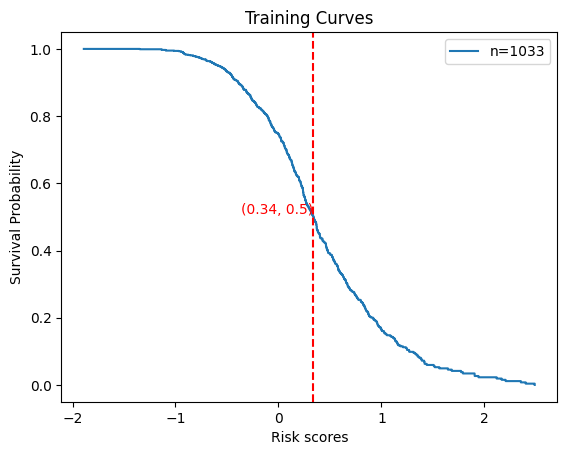

In [12]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
# time_high, survival_prob_high = kaplan_meier_estimator(test['riskscore'].astype("bool"),test['Recurrence free survival'])
time_high, survival_prob_high = kaplan_meier_estimator(train['Recur'].astype("bool"),train['riskscore'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count = len(train)
plt.step(time_high, survival_prob_high, where="post",label=f'n={count}')
plt.xlabel('Risk scores')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Training Curves')
plt.legend()
# 找到 ylabel 為 0.5 的對應 xlabel 數值
ylabel_0_5 = 0.5
index = np.abs(survival_prob_high - ylabel_0_5).argmin()
xlabel_at_0_5 = time_high[index]
plt.axvline(x=xlabel_at_0_5, color='red', linestyle='--')
plt.text(xlabel_at_0_5, ylabel_0_5, f'{xlabel_at_0_5.round(2),ylabel_0_5}', color='red', ha='right', va='bottom')


plt.savefig('./result/統計圖表/Training Curves(OP_post).png')
plt.show()

In [14]:
for i in range(len(test_X_std)):
    print("ID: {}, Risk Score: {}".format(test_X_std.index[i], preds[i]))

ID: 0, Risk Score: 0.15433679467914807
ID: 1, Risk Score: 1.2721895544311577
ID: 2, Risk Score: 0.5829809858311206
ID: 3, Risk Score: 0.8568001283407217
ID: 4, Risk Score: -0.2748698538050796
ID: 5, Risk Score: -0.31717280084470745
ID: 6, Risk Score: 0.6850944306854112
ID: 7, Risk Score: 0.24345287665294907
ID: 8, Risk Score: 0.2633162219068401
ID: 9, Risk Score: -0.23483023409261172
ID: 10, Risk Score: 0.2589353154906855
ID: 11, Risk Score: 0.42537400581588436
ID: 12, Risk Score: -0.10045920065274455
ID: 13, Risk Score: -0.22617813568984363
ID: 14, Risk Score: -0.1916055452949582
ID: 15, Risk Score: 0.16266127635043487
ID: 16, Risk Score: 0.9439458494173605
ID: 17, Risk Score: 0.7237598429932703
ID: 18, Risk Score: -0.05133363596236752
ID: 19, Risk Score: -0.5847901377660265
ID: 20, Risk Score: 0.19876655300486945
ID: 21, Risk Score: 0.12732731097064004
ID: 22, Risk Score: 0.002517332013693821
ID: 23, Risk Score: -0.036925538337527625
ID: 24, Risk Score: -0.4735857700305541
ID: 25, Ri

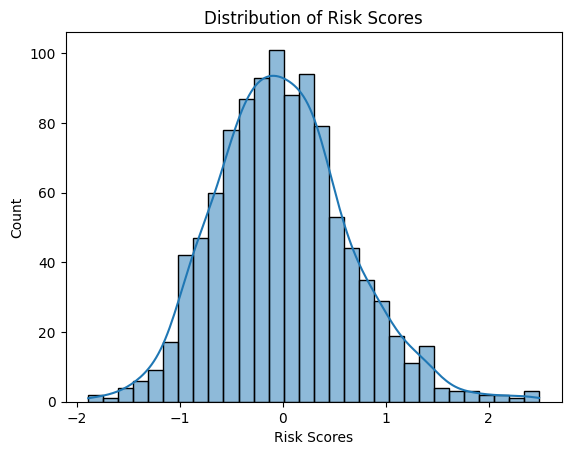

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of Risk Scores')
plt.show()

以人數30%切點切出risk score當作threshold

Threshold at 30%: -0.4244191102017738


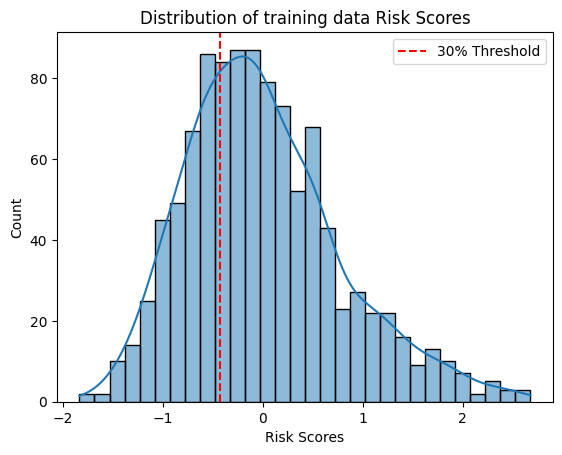

In [41]:
# 將 preds_train 由低至高排序
sorted_preds = sorted(preds_train)

# 計算第 70% 的索引位置
index_70_percent = int(0.32 * len(sorted_preds))

# 印出第 70% 的數值
threshold_70_percent = sorted_preds[index_70_percent]
print("Threshold at 30%:", threshold_70_percent)

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')
plt.axvline(x=threshold_70_percent, color='red', linestyle='--', label='30% Threshold')
plt.legend()
# plt.savefig('./data_cluster/統計圖表/train1.png')
plt.show()

以train的95%信賴區間切三等份當作threshold

Cut Point 1: -1.2485442530631845
Cut Point 2: 1.8505131351420279


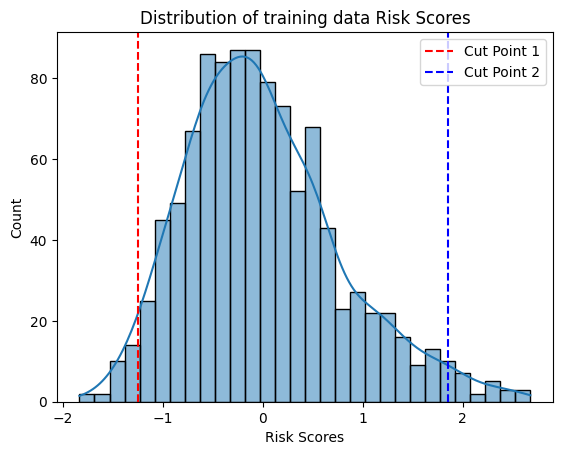

In [42]:
import numpy as np

# 計算 95% 信賴區間
lower_bound = np.percentile(preds_train, 2.5)
upper_bound = np.percentile(preds_train, 97.5)

# 將信賴區間分成三等分的切點
cut_points = [lower_bound, upper_bound]

# 分割資料成三個區間
low_data = preds_train[preds_train <= cut_points[0]]
medium_data = preds_train[(preds_train > cut_points[0]) & (preds_train < cut_points[1])]
high_data = preds_train[preds_train >= cut_points[1]]

# 列印切點數值
print("Cut Point 1:", cut_points[0])
print("Cut Point 2:", cut_points[1])

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')

# 繪製切點垂直線
plt.axvline(x=cut_points[0], color='red', linestyle='--', label='Cut Point 1')
plt.axvline(x=cut_points[1], color='blue', linestyle='--', label='Cut Point 2')
plt.legend()
plt.show()


Cut Point 1: -0.2924424373429265
Cut Point 2: 0.5446781970613734


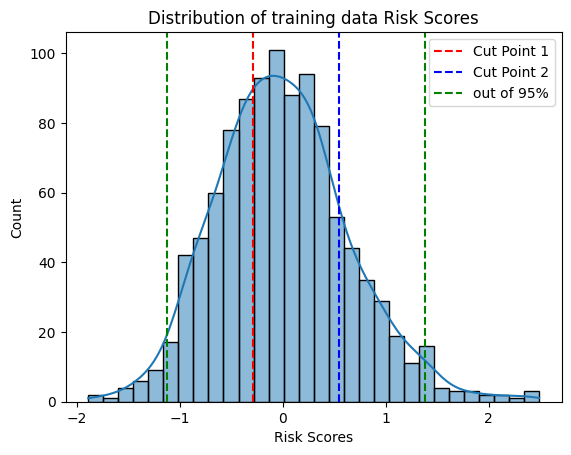

In [11]:
import numpy as np

# 計算 95% 信賴區間
lower_bound = np.percentile(preds_train, 2.5)
upper_bound = np.percentile(preds_train, 97.5)
cut_points = [lower_bound, upper_bound]
# 將信賴區間切成三等份的切點
cut_point1 = lower_bound + (upper_bound - lower_bound) / 3
cut_point2 = lower_bound + (upper_bound - lower_bound) * 2 / 3

# 列印切點數值
print("Cut Point 1:", cut_point1)
print("Cut Point 2:", cut_point2)

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')

# 繪製切點垂直線
plt.axvline(x=cut_point1, color='red', linestyle='--', label='Cut Point 1')
plt.axvline(x=cut_point2, color='blue', linestyle='--', label='Cut Point 2')
plt.axvline(x=cut_points[0], color='green', linestyle='--', label='out of 95%')
plt.axvline(x=cut_points[1], color='green', linestyle='--')
plt.legend()
#plt.savefig('./data_cluster/統計圖表/train 95% .png')
plt.show()


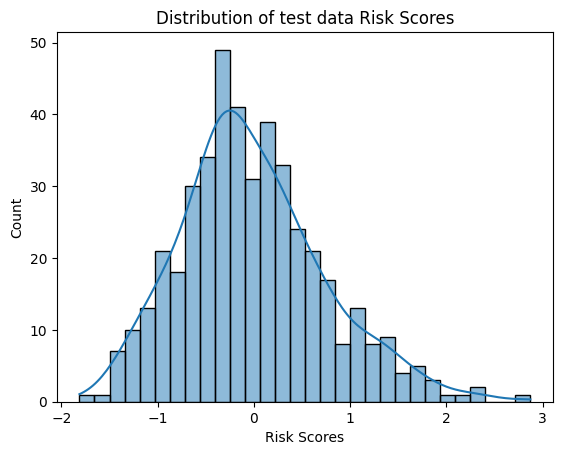

In [44]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(preds, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of test data Risk Scores')
#plt.savefig('./data_cluster/統計圖表/test1.png')
plt.show()


In [12]:
train_low = train[ preds_train <=-0.29 ]
train_med = train[ (preds_train > -0.29) & (preds_train <0.55) ]
train_high = train[ preds_train >= 0.55 ]

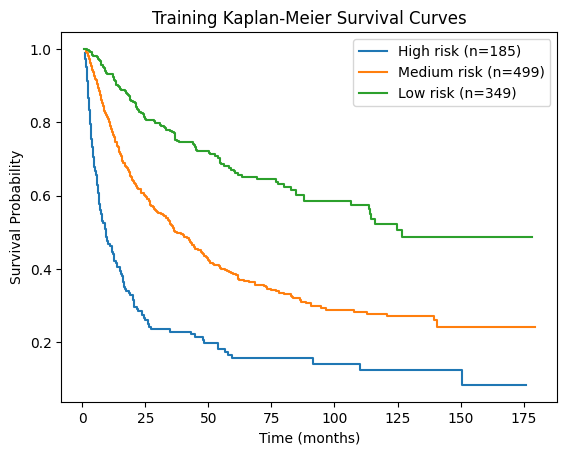

In [13]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(train_high['Recur'].astype("bool"),train_high['Recurrence free survival'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(train_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_med, survival_prob_med = kaplan_meier_estimator(train_med['Recur'].astype("bool"),train_med['Recurrence free survival'])
#plt.plot(time_med, survival_prob_med, drawstyle='steps-post', label="steps-post")
count_med = len(train_med)
plt.step(time_med, survival_prob_med, where="post",label=f'Medium risk (n={count_med})')

time_low, survival_prob_low = kaplan_meier_estimator(train_low['Recur'].astype("bool"),train_low['Recurrence free survival'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(train_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

#plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Training Kaplan-Meier Survival Curves')
plt.legend()
#plt.savefig('./result/統計圖表/Training kmplot high low med(OP_post).png')
plt.show()


In [14]:
test_low = test[ preds <=-0.29 ]
test_med = test[ (preds > -0.29) & (preds <0.55) ]
test_high = test[ preds >= 0.55 ]

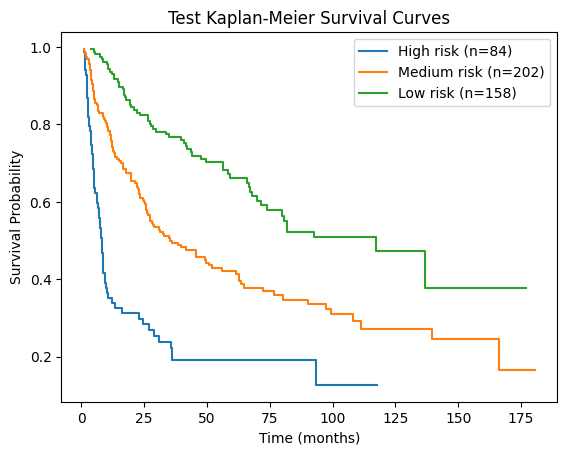

In [16]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(test_high['Recur'].astype("bool"),test_high['Recurrence free survival'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_med, survival_prob_med = kaplan_meier_estimator(test_med['Recur'].astype("bool"),test_med['Recurrence free survival'])
#plt.plot(time_med, survival_prob_med, drawstyle='steps-post', label="steps-post")
count_med = len(test_med)
plt.step(time_med, survival_prob_med, where="post",label=f'Medium risk (n={count_med})')

time_low, survival_prob_low = kaplan_meier_estimator(test_low['Recur'].astype("bool"),test_low['Recurrence free survival'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

#plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Test Kaplan-Meier Survival Curves')
plt.legend()
# plt.savefig('./result/統計圖表/test kmplot high low med(OP_post).png')
plt.show()


In [13]:
test_low = test[ preds <= 0.34]
test_high = test[ preds > 0.34 ]

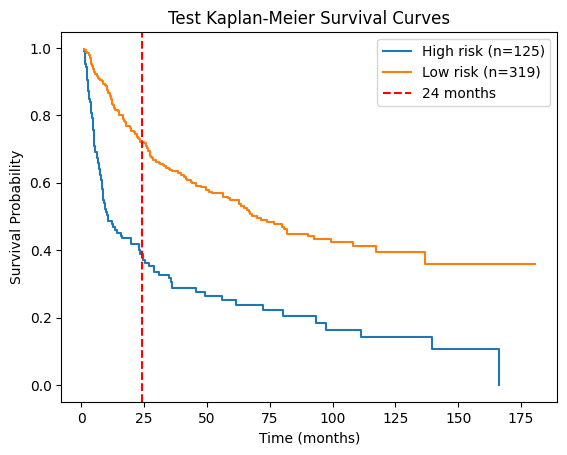

In [14]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(test_high['Recur'].astype("bool"),test_high['Recurrence free survival'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_low, survival_prob_low = kaplan_meier_estimator(test_low['Recur'].astype("bool"),test_low['Recurrence free survival'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Test Kaplan-Meier Survival Curves')
plt.legend()
plt.savefig('./result/統計圖表/Test km_plot high low(OP_post).png')
plt.show()


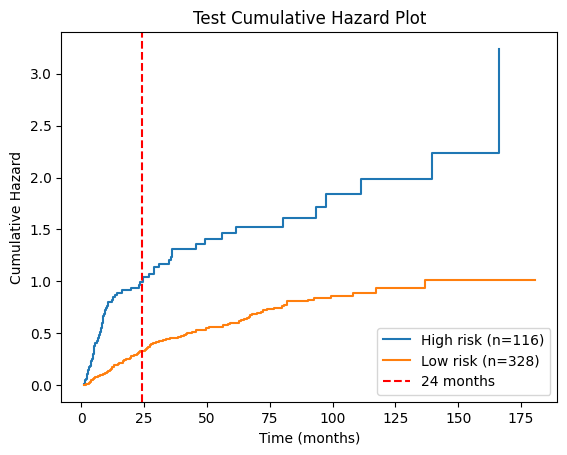

In [23]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = nelson_aalen_estimator(test_high['Recur'].astype("bool"),test_high['Recurrence free survival'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_low, survival_prob_low = nelson_aalen_estimator(test_low['Recur'].astype("bool"),test_low['Recurrence free survival'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Cumulative Hazard')
# 設定圖表的標題
plt.title('Test Cumulative Hazard Plot')
plt.legend()
plt.savefig('./result/統計圖表/Test Cumulative Hazard Plot high low(OP_post).png')
plt.show()


建立非線性模型

In [23]:
train = pd.read_csv('./data/RFA_lnV2_noISD_train_0419_std.csv')
test = pd.read_csv('./data/RFA_lnV2_noISD_test_0419_std.csv')

In [24]:
selected = ['lnPLAT','CR' ,'APRI' ,'FIB4' ,'BUN', 'Tumor size' ,'PTINR' ,'lnALT','Child_Class','AFP' ,'Weight']#gen=100 conv_gen=30 survtree

In [25]:
X = train[ selected ]
y_struct = train[['Recur', 'Recurrence free survival']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])

In [26]:
test_X_std = test[train.columns].drop(columns=['Recur', 'Recurrence free survival'])
test_X_std = test_X_std[selected]

SurvivalTree

In [27]:
from sksurv.tree import SurvivalTree

estimator = SurvivalTree().fit(X, y_struct)

preds = estimator.predict(test_X_std)

concordance_index_censored(test['Recur'] > 0, test['Recurrence free survival'],preds)


(0.5157909381811436, 10834, 10153, 576, 1)

In [29]:
preds = estimator.predict(X)
concordance_index_censored(train['Recur'] > 0, train['Recurrence free survival'],preds)

(0.8682501376010838, 102287, 15310, 498, 25)

RandomSurvivalForest

In [47]:
combined[ (combined['Recur']==1) & (combined['Recurrence free survival'] <=24) ].index

Int64Index([  0,   2,   4,   5,   8,   9,  10,  11,  13,  14,
            ...
            137, 138, 139, 140, 142, 143, 144, 146, 147, 149],
           dtype='int64', length=355)

<AxesSubplot: ylabel='Count'>

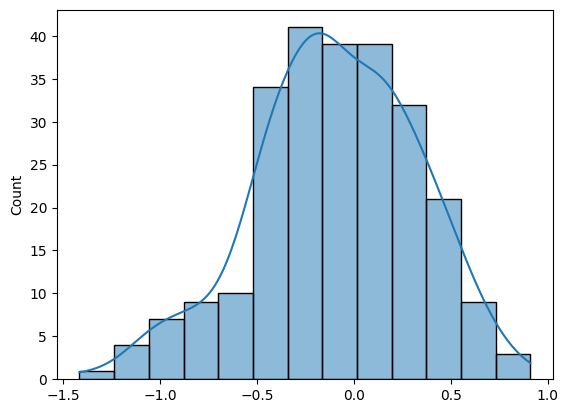

In [53]:
sns.histplot([ preds_all[idx] for idx in combined[ (combined['Recur']==0)  ].index ], kde=True)

<AxesSubplot: ylabel='Count'>

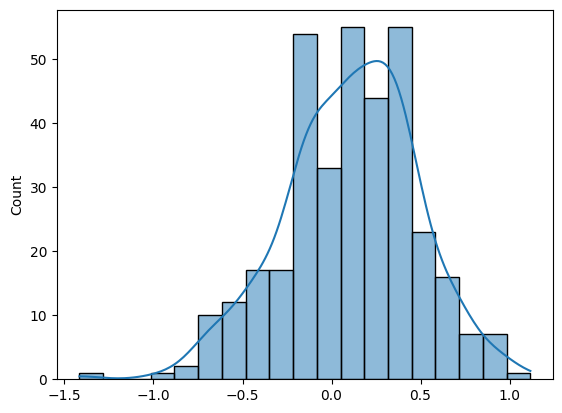

In [51]:
sns.histplot([ preds_all[idx] for idx in combined[ (combined['Recur']==1) & (combined['Recurrence free survival'] <=24) ].index ], kde=True)